In [2]:
import pandas as pd
from plotly.graph_objects import *
from plotly.offline import init_notebook_mode,iplot
init_notebook_mode(connected=True)
import plotly.express as px
from statsmodels.tsa.seasonal import seasonal_decompose
from plotly.subplots import make_subplots
import warnings
from sklearn.metrics import mean_absolute_error, r2_score
warnings.filterwarnings('ignore')

from statsmodels.tsa.holtwinters import SimpleExpSmoothing, Holt, ExponentialSmoothing



In [3]:
df = pd.read_csv('https://raw.githubusercontent.com/robot-dreams-code/Machine-Learning-2/main/datasets/airline-passengers.csv?token=GHSAT0AAAAAACBLQFT2WYE64LE7PK4CE6OAZCJWERA')
df.head()



,Month,Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


In [4]:
px.line(df, x = 'Month', y = 'Passengers')


In [5]:
df['Month'] = pd.to_datetime(df['Month']) # конвертація в дейт тайм
s = pd.Series(index=df['Month'],
             data = df['Passengers'].values)
s
print(df.dtypes)



Month         datetime64[ns]
Passengers             int64
dtype: object


In [6]:
result = seasonal_decompose(s, model='additive') #additive or multiplicative
result

result_mult = seasonal_decompose(s, model='multiplicative') #additive or multiplicative
result_mult
#print(result.trend) #reasudual seasonable
#print(result.resid) #reasudual seasonable
#print(result.seasonal) #reasudual seasonable


In [7]:
fig = make_subplots(rows= 3, cols = 1)

fig.append_trace(Scatter(x = result.trend.index,
                        y = result.trend.values,
                        name = 'Trend_add'),
                row = 1, col = 1)
fig.append_trace(Scatter(x = result.seasonal.index,
                        y = result.seasonal.values,
                        name = 'Seasonal_add'),
                row = 2, col = 1)
fig.append_trace(Scatter(x = result.resid.index,
                        y = result.resid.values,
                        name = 'Residual_add'),
                row = 3, col = 1)
fig.show()

In [8]:
fig = make_subplots(rows= 3, cols = 1)

fig.append_trace(Scatter(x = result_mult.trend.index,
                        y = result.trend.values,
                        name = 'Trend_mult'),
                row = 1, col = 1)
fig.append_trace(Scatter(x = result_mult.seasonal.index,
                        y = result_mult.seasonal.values,
                        name = 'Seasonal_mult'),
                row = 2, col = 1)
fig.append_trace(Scatter(x = result_mult.resid.index,
                        y = result_mult.resid.values,
                        name = 'Residual_mult'),
                row = 3, col = 1)
fig.show()

In [ ]:
px.histogram(x = result.resid.values)


In [ ]:
px.histogram(x = result_mult.resid.values)

In [9]:
df['yhat_simple'] = df['Passengers'].shift(1) # модель прозноз дорівює попередньому значенню
df




,Month,Passengers,yhat_simple
0,1949-01-01,112,NaN
1,1949-02-01,118,112.0
2,1949-03-01,132,118.0
3,1949-04-01,129,132.0
4,1949-05-01,121,129.0
...,...,...,...
139,1960-08-01,606,622.0
140,1960-09-01,508,606.0
141,1960-10-01,461,508.0
142,1960-11-01,390,461.0


In [10]:
px.line(df, x = 'Month', y = ['Passengers','yhat_simple']) #прогноз на 1 місяць, на 1 крок вперед




In [ ]:
df['yhat_year'] = df['Passengers'].shift(12) # прогноз на 12 # застосувати на сезонну компоненту
px.line(df, x = 'Month', y = ['Passengers','yhat_year'])

In [11]:
from sklearn.model_selection import TimeSeriesSplit
tscv = TimeSeriesSplit(test_size=18) #прогноз на рік https://academy.yandex.ru/handbook/ml/article/kross-validaciya





In [12]:
trace0 = Scatter(x = s.index,
                y = s.values,
                line = {'color': 'grey'},
                name = 'Original data')
for i, (train_index, test_index) in enumerate(tscv.split(s)):
    train = s[train_index]
    test = s[test_index]
    
    trace1 = Scatter(x = train.index,
                    y= train.values,
                    name = 'Train')
    trace2 = Scatter(x = test.index,
                    y= test.values,
                    name = 'test')
    
    iplot(Figure(data = [trace0, trace1, trace2]))






In [13]:
train, test = s[0:-12], s[-12:] # розділили тест та трейн
ses = SimpleExpSmoothing(train) # просте експоненційне згладжування

ses_fitted = ses.fit(smoothing_level=0.8) 
ses_fitted.fittedvalues



Month
1949-01-01    113.728445
1949-02-01    112.345689
1949-03-01    116.869138
1949-04-01    128.973828
1949-05-01    128.994766
                 ...    
1959-08-01    530.524340
1959-09-01    553.304868
1959-10-01    481.060974
1959-11-01    421.812195
1959-12-01    373.962439
Length: 132, dtype: float64

In [ ]:
iplot(Figure(data = [Scatter(x = train.index, y = train.values,
                            name = 'Train'),
                    Scatter(x = ses_fitted.fittedvalues.index,
                           y = ses_fitted.fittedvalues.values,
                           name = 'Prediction')]))

In [14]:
ses_fitted.forecast(len(test))

1960-01-01    398.792488
1960-02-01    398.792488
1960-03-01    398.792488
1960-04-01    398.792488
1960-05-01    398.792488
1960-06-01    398.792488
1960-07-01    398.792488
1960-08-01    398.792488
1960-09-01    398.792488
1960-10-01    398.792488
1960-11-01    398.792488
1960-12-01    398.792488
Freq: MS, dtype: float64

In [15]:
holt = Holt(train) # алгоритм тройного экспоненциального сглаживания
holt_fitted = holt.fit(smoothing_level=0.8, smoothing_trend=0.8)
iplot(Figure(data = [Scatter(x = train.index, y = train.values,
                            name = 'Train'),
                    Scatter(x = holt_fitted.fittedvalues.index,
                           y = holt_fitted.fittedvalues.values,
                           name = 'Prediction')]))


In [16]:
holt_fitted.forecast(len(test))




1960-01-01    392.767693
1960-02-01    401.871883
1960-03-01    410.976072
1960-04-01    420.080262
1960-05-01    429.184451
1960-06-01    438.288641
1960-07-01    447.392830
1960-08-01    456.497020
1960-09-01    465.601209
1960-10-01    474.705398
1960-11-01    483.809588
1960-12-01    492.913777
Freq: MS, dtype: float64

In [17]:
mod = ExponentialSmoothing(train,
                          trend = 'add',
                          seasonal='add',
                          seasonal_periods=12)
mod_fit = mod.fit()
preds = mod_fit.forecast(len(test))
preds


1960-01-01    415.454504
1960-02-01    397.087978
1960-03-01    457.470087
1960-04-01    445.367944
1960-05-01    466.186561
1960-06-01    520.730604
1960-07-01    592.422802
1960-08-01    598.842971
1960-09-01    498.828449
1960-10-01    442.382473
1960-11-01    396.515020
1960-12-01    424.291227
Freq: MS, dtype: float64

In [ ]:
#iplot(Figure([Scatter(x = test.index,
#                     y = test.values,
#                     name = 'Test data'),
#             Scatter(x = preds.index,
#                    y = preds.values,
#                    name = 'Prediction')]))
#from sklearn.metrics import r2_score


In [18]:
r2_score(test, preds)

0.9479522235035107

In [19]:
mod = ExponentialSmoothing(train,
                          trend = 'mul',
                          seasonal='mul',
                          seasonal_periods=12)
mod_fit = mod.fit()
preds_mul = mod_fit.forecast(len(test))
preds_mul

1960-01-01    420.907787
1960-02-01    399.216639
1960-03-01    470.319383
1960-04-01    458.255978
1960-05-01    483.832447
1960-06-01    556.246838
1960-07-01    644.518246
1960-08-01    654.619823
1960-09-01    537.144259
1960-10-01    470.786453
1960-11-01    414.192827
1960-12-01    448.648474
Freq: MS, dtype: float64

In [ ]:
iplot(Figure([Scatter(x = test.index,
                     y = test.values,
                     name = 'Test data'),
             Scatter(x = preds.index,
                    y = preds.values,
                    name = 'Prediction_add'),
             Scatter(x = preds_mul.index,
                    y = preds_mul.values,
                    name = 'Prediction_mul')]))

In [ ]:
r2_score(test, preds_mul) #мультиплікативна гірша

In [38]:
from prophet import Prophet #https://www.kaggle.com/code/prashant111/tutorial-time-series-forecasting-with-prophet
my_model = Prophet(interval_width=0.95)

In [39]:
f_train = pd.DataFrame(train)
f_train = f_train.rename_axis(None)
#f_train.index.rename('ds', inplace= True )
print(list(f_train))
f_train.head()
f_train.columns=['y']
f_train['ds'] = f_train.index

f_train.head()
# Fit the model

my_model.fit(f_train)


01:25:14 - cmdstanpy - INFO - Chain [1] start processing
01:25:14 - cmdstanpy - INFO - Chain [1] done processing


[0]


In [45]:


# create date to predict
future_dates = my_model.make_future_dataframe(periods=12, freq='MS')

# Make predictions
predictions = my_model.predict(future_dates)

predictions[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head()

#Prophet returns a large DataFrame with many interesting columns, but we subset our output to the columns most relevant to forecasting. These are:

#ds: the datestamp of the forecasted value
#yhat: the forecasted value of our metric (in Statistics, yhat is a notation traditionally used to represent the predicted values of a value y)
#yhat_lower: the lower bound of our forecasts
#yhat_upper: the upper bound of our forecasts

,ds,yhat,yhat_lower,yhat_upper
0,1949-01-01,85.137741,42.685224,125.612811
1,1949-02-01,78.743891,35.305632,116.115241
2,1949-03-01,116.458144,78.498292,157.343146
3,1949-04-01,109.235414,72.295151,147.667887
4,1949-05-01,112.150302,73.192515,148.566347


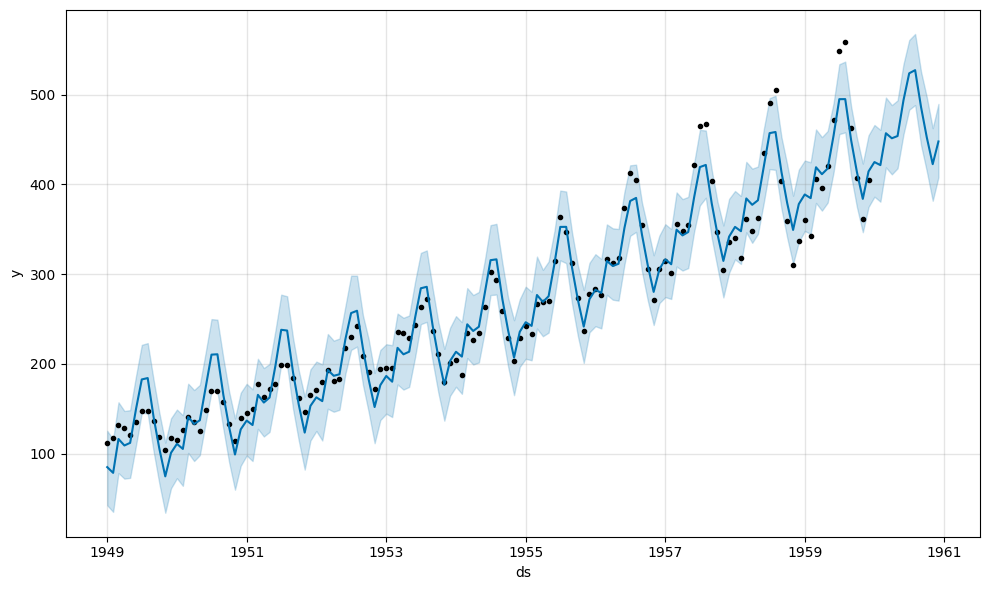

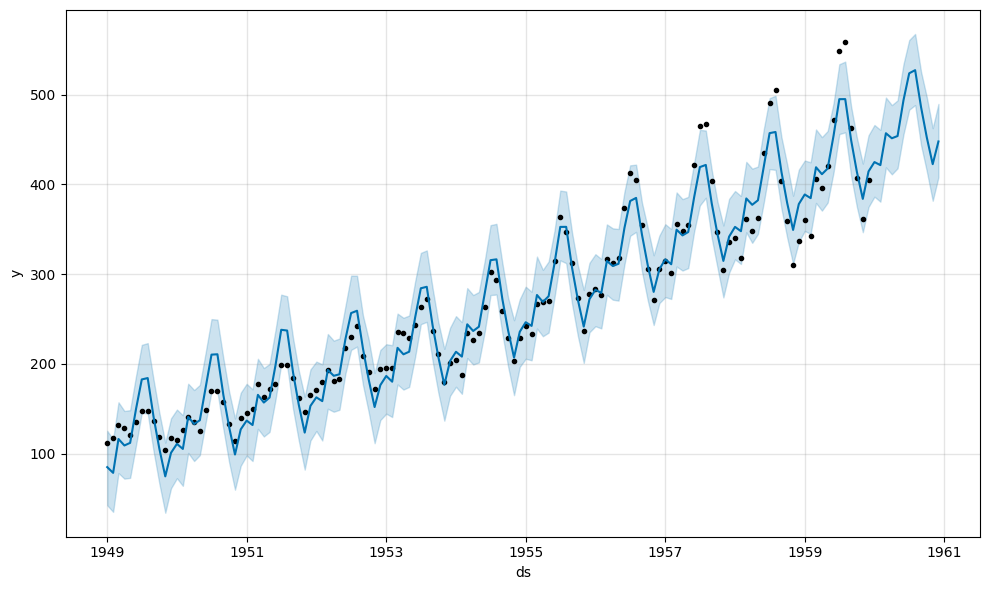

In [46]:
my_model.plot(predictions, uncertainty=True)

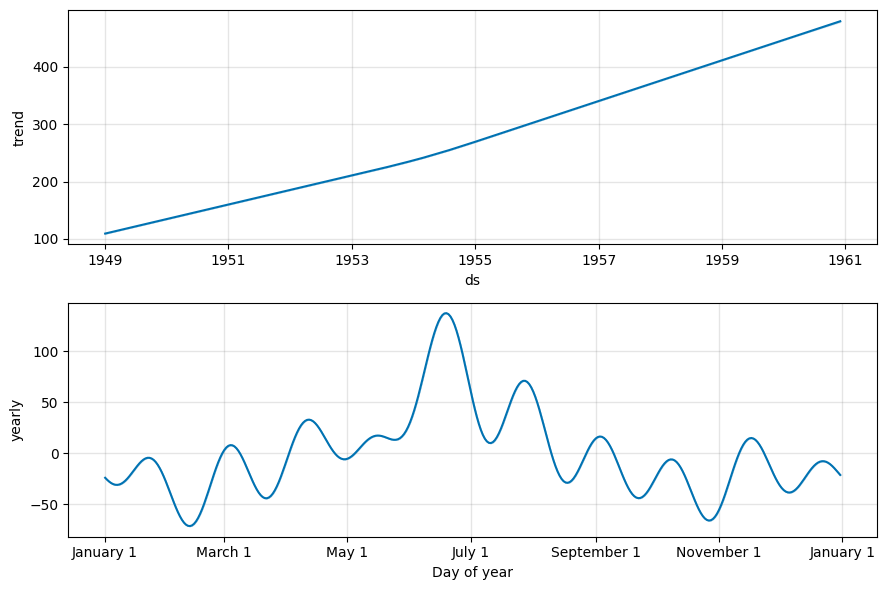

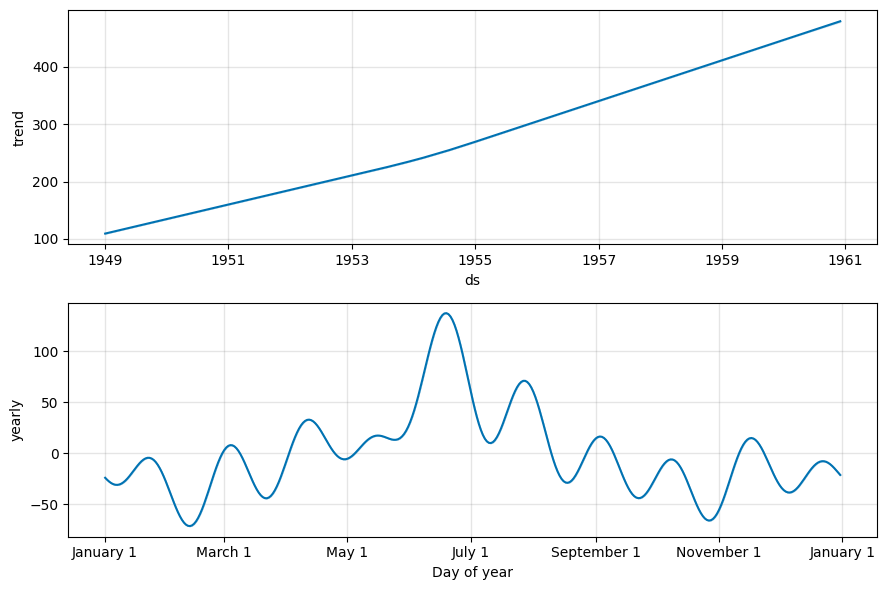

In [47]:
my_model.plot_components(predictions)

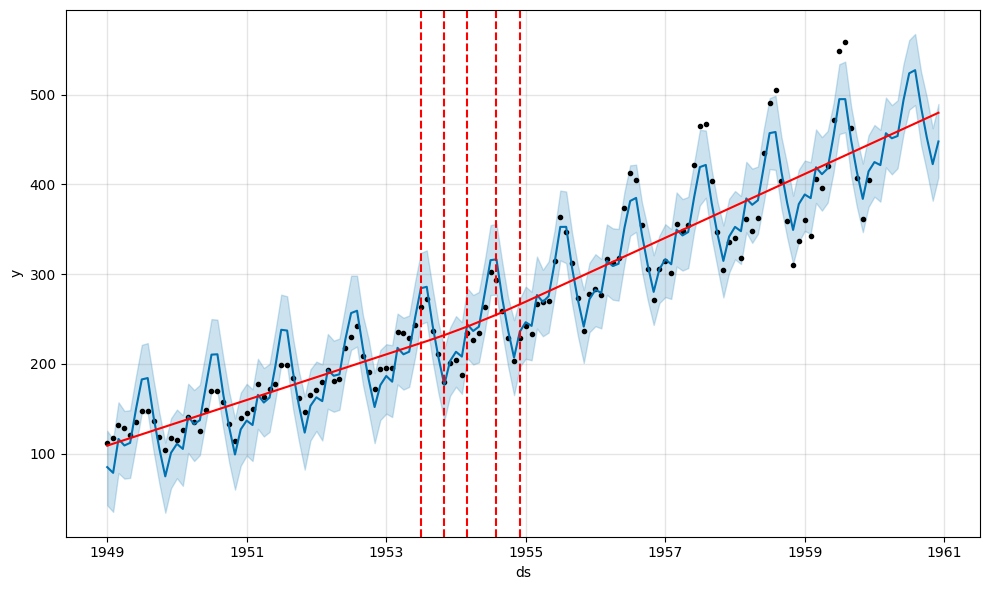

In [49]:
from prophet.plot import add_changepoints_to_plot
fig = my_model.plot(predictions)
a = add_changepoints_to_plot(fig.gca(), my_model, predictions)

01:37:44 - cmdstanpy - INFO - Chain [1] start processing
01:37:44 - cmdstanpy - INFO - Chain [1] done processing


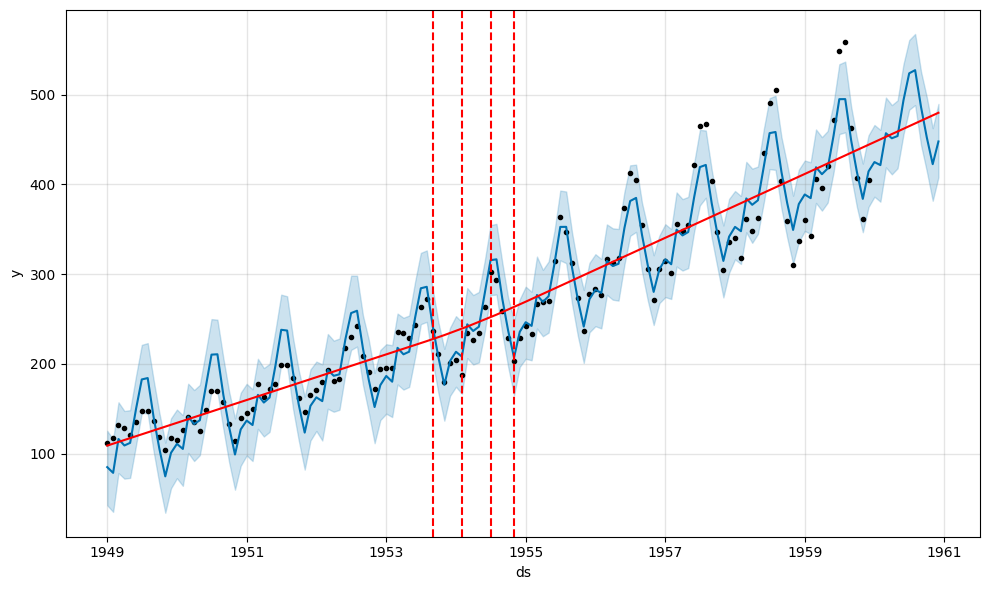

In [52]:
pro_change= Prophet(changepoint_range=0.9)
forecast = pro_change.fit(f_train).predict(future_dates)
fig= pro_change.plot(predictions);
a = add_changepoints_to_plot(fig.gca(), pro_change, predictions)